In [1]:
# Import necessary libraries
import os
import re
import mne
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

onedir = 'C:\\Users\\tyalb\\OneDrive\\Documents\\'
onedir = 'C:\\Users\\tyler_p5hze3w\\OneDrive\\Documents\\'
pydir = onedir + 'python_code\\'
matdir = onedir + 'MATLAB\\'
wsdir = matdir + 'Walking_Study_EEG\\'
datadir = pydir + 'python_projects\\SIPLab\\iEEG\\processed_data\\'

## Load data

In [2]:
data_files = os.listdir(datadir)
data_files = [data_file for data_file in data_files if 'participant' not in data_file]

# partition the data into soz labeled and non soz labeled participants
all_run_data_no_soz = {}
all_run_data_no_soz['ecog_x'] = []
all_run_data_no_soz['stim_x'] = []
all_run_data_no_soz['ecog_pos_x'] = []
all_run_data_no_soz['ecog_ch_name_x'] = []
all_run_data_no_soz['ecog_loc_text_y'] = []
all_run_data_no_soz['ecog_loc_idx_y'] = []
all_run_data_no_soz['condition_x'] = {}
all_run_data_no_soz['subject'] = []
all_run_data_no_soz['condition_x']['age'] = []
all_run_data_no_soz['condition_x']['sex'] = []
all_run_data_no_soz['condition_x']['stim_xyz'] = []
all_run_data_no_soz['condition_x']['node_xyz'] = []

all_run_data_soz = {}
all_run_data_soz['ecog_x'] = []
all_run_data_soz['stim_x'] = []
all_run_data_soz['ecog_pos_x'] = []
all_run_data_soz['ecog_ch_name_x'] = []
all_run_data_soz['soz_y'] = []
all_run_data_soz['ecog_loc_text_y'] = []
all_run_data_soz['ecog_loc_idx_y'] = []
all_run_data_soz['condition_x'] = {}
all_run_data_soz['subject'] = []
all_run_data_soz['condition_x']['age'] = []
all_run_data_soz['condition_x']['sex'] = []
all_run_data_soz['condition_x']['stim_xyz'] = []
all_run_data_soz['condition_x']['node_xyz'] = []

num_labeled = 0
all_soz_locs = []

for data_file in data_files:
    with open(datadir + data_file,'rb') as file:
        run_data = pickle.load(file)
        soz_labeled = np.count_nonzero(run_data[0]['soz_labels']) > 0
        if soz_labeled:
            num_labeled += 1

        for trial_key,trial_data in run_data.items():

            # get subject info
            subject_info = trial_data['subject_info']
            if trial_data['subject_info']['sex'] == 'male':
                sex = 0
            else:
                sex = 1
            if soz_labeled:
                all_run_data_soz['subject'].append(int(re.findall(r'\d+',subject_info['subject_id'])[0]))
                all_run_data_soz['condition_x']['age'].append(subject_info['age'])
                all_run_data_soz['condition_x']['sex'].append(sex)
            else:
                all_run_data_no_soz['subject'].append(int(re.findall(r'\d+',trial_data['subject_info']['subject_id'])[0]))
                all_run_data_no_soz['condition_x']['age'].append(trial_data['subject_info']['age'])
                all_run_data_no_soz['condition_x']['sex'].append(sex)

            # get electrode location info
            stim_info = trial_data['stim_info']
            if soz_labeled:
                all_run_data_soz['condition_x']['stim_xyz'].append(stim_info['stim_xyz'])
            else:
                all_run_data_no_soz['condition_x']['stim_xyz'].append(stim_info['stim_xyz'])

            ch_info = trial_data['ch_info']
            trial_ch_pos = []
            trial_ch_name = []
            trial_ch_loc_text = []
            trial_ch_loc_idx = []
            for ch_key,ch_data in ch_info.items():
                trial_ch_name.append(ch_key)
                trial_ch_pos.append(ch_data['xyz'])
                trial_ch_loc_text.append(ch_data['Destrieux_label_text'])
                trial_ch_loc_idx.append(ch_data['Destrieux_label'])
            trial_ch_pos = np.array(trial_ch_pos)
            trial_ch_loc_idx = np.array(trial_ch_loc_idx)
            if soz_labeled:
                all_run_data_soz['ecog_pos_x'].append(trial_ch_pos)
                all_run_data_soz['ecog_ch_name_x'].append(trial_ch_name)
                all_run_data_soz['ecog_loc_text_y'].append(trial_ch_loc_text)
                all_run_data_soz['ecog_loc_idx_y'].append(trial_ch_loc_idx)
            else:
                all_run_data_no_soz['ecog_pos_x'].append(trial_ch_pos)
                all_run_data_no_soz['ecog_ch_name_x'].append(trial_ch_name)
                all_run_data_no_soz['ecog_loc_text_y'].append(trial_ch_loc_text)
                all_run_data_no_soz['ecog_loc_idx_y'].append(trial_ch_loc_idx)

            # get timeseries data (X) and labels (y)
            if soz_labeled:
                all_run_data_soz['ecog_x'].append(trial_data['ecog_data'])
                all_run_data_soz['stim_x'].append(trial_data['stim_data'].T)
                all_run_data_soz['soz_y'].append(trial_data['soz_labels'])
            else:
                all_run_data_no_soz['ecog_x'].append(trial_data['ecog_data'])
                all_run_data_no_soz['stim_x'].append(trial_data['stim_data'].T)


## Dataset Preparation

In [3]:
from sklearn.model_selection import KFold
soz_unique_subjects = np.unique(all_run_data_soz['subject'])
no_soz_unique_subjects = np.unique(all_run_data_no_soz['subject'])
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(soz_unique_subjects))

iSplit = 0
train_idx = np.concatenate([folds[0][1],
                            folds[1][1],
                            folds[2][1]])
val_idx = folds[3][1]
test_idx = folds[4][1]
train_subjects = soz_unique_subjects[train_idx]
train_no_soz_subjects = no_soz_unique_subjects
val_subjects = soz_unique_subjects[val_idx]
test_subjects = soz_unique_subjects[test_idx]

print(len(soz_unique_subjects),len(no_soz_unique_subjects))
print(train_no_soz_subjects)
print(train_subjects)
print(val_subjects)
print(test_subjects)

with open('.\\soz_cat_labels.pkl','rb') as file:
    all_soz_labels = pickle.load(file)

with open('.\\res_cat_labels.pkl','rb') as file:
    all_res_labels = pickle.load(file)

with open('.\\soz_xyz_centers.pkl','rb') as file:
    all_soz_xyz = pickle.load(file)

print(all_soz_labels)


36 38
[ 1  2  3  4  5  6  8  9 10 11 12 13 14 16 18 19 20 22 23 24 25 27 30 32
 34 43 50 54 56 64 66 67 68 70 71 72 73 74]
[38 39 42 48 55 60 61 69  7 26 33 35 44 59 65 15 17 28 37 41 46 52]
[21 36 49 51 57 62 63]
[29 31 40 45 47 53 58]
{7: 'Temporal', 15: 'Temporal', 17: 'Precuneus', 21: 'Frontal', 26: 'Frontal', 28: 'Temporal', 29: 'Limbic', 31: 'Temporal', 33: 'Parietal', 35: 'Temporal', 36: 'Parietal', 37: 'Frontal', 38: 'Frontal', 39: 'Frontal', 40: 'Frontal', 41: 'Temporal', 42: 'Temporal', 44: 'Precuneus', 45: 'Frontal', 46: 'Frontal', 47: 'Temporal', 48: 'Parietal', 49: 'Frontal', 51: 'Parietal', 52: 'Frontal', 53: 'Limbic', 55: 'Parietal', 57: 'Temporal', 58: 'Temporal', 59: 'Frontal', 60: 'Temporal', 61: 'Temporal', 62: 'Parietal', 63: 'Temporal', 65: 'Temporal', 69: 'Temporal'}


In [4]:
all_subject_ids = np.array(list(all_soz_labels.keys()))
soz_unique_subjects = np.unique(all_run_data_soz['subject'])
print(soz_unique_subjects)
stratification_labels = np.array([all_soz_labels[sub_id] for sub_id in all_subject_ids])
print(stratification_labels)

[ 7 15 17 21 26 28 29 31 33 35 36 37 38 39 40 41 42 44 45 46 47 48 49 51
 52 53 55 57 58 59 60 61 62 63 65 69]
['Temporal' 'Temporal' 'Precuneus' 'Frontal' 'Frontal' 'Temporal' 'Limbic'
 'Temporal' 'Parietal' 'Temporal' 'Parietal' 'Frontal' 'Frontal' 'Frontal'
 'Frontal' 'Temporal' 'Temporal' 'Precuneus' 'Frontal' 'Frontal'
 'Temporal' 'Parietal' 'Frontal' 'Parietal' 'Frontal' 'Limbic' 'Parietal'
 'Temporal' 'Temporal' 'Frontal' 'Temporal' 'Temporal' 'Parietal'
 'Temporal' 'Temporal' 'Temporal']


In [5]:
from sklearn.model_selection import KFold
soz_unique_subjects = np.unique(all_run_data_soz['subject'])
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(soz_unique_subjects))
train_val_idx = np.concatenate([folds[0][1],
                            folds[1][1],
                            folds[2][1]])
val_idx = folds[3][1]
print(train_idx,val_idx)
train_subjects = soz_unique_subjects[train_idx]
train_no_soz_subjects = no_soz_unique_subjects
val_subjects = soz_unique_subjects[val_idx]
test_subjects = soz_unique_subjects[test_idx]

def get_subject_data(all_data,subjects,y_out=True):

    X = all_data['ecog_x']
    Xstim = all_data['stim_x']
    Xpos = all_data['ecog_pos_x']
    Xname = all_data['ecog_ch_name_x']
    y_loc_text = all_data['ecog_loc_text_y']
    y_loc_idx = all_data['ecog_loc_idx_y']
    if y_out:
        y = all_data['soz_y']
    c = all_data['condition_x']
    sids = all_data['subject']

    X_split = [] # training data
    Xstim_split = [] # training data
    Xpos_split = [] # training data 
    Xname_split = []
    y_loc_text_split = []
    y_loc_idx_split = []
    if y_out:
        y_split = [] # labels
    c_split = [] # conditions
    sids_split = [] # trial subject ids
    s_split = [] # subject info

    for subject in subjects:
        subject_trials = np.argwhere(sids == subject)[:,0]
        for iTrial in subject_trials:
            # append the data and labels
            X_split.append(X[iTrial][:,:,None])
            Xstim_split.append(Xstim[iTrial])
            Xpos_split.append(Xpos[iTrial])
            Xname_split.append(Xname[iTrial])
            y_loc_text_split.append(y_loc_text[iTrial])
            y_loc_idx_split.append(y_loc_idx[iTrial])
            if y_out:
                y_split.append(y[iTrial])
            sids_split.append(subject)

            # stack conditions into one array
            c_trial = np.concatenate((
                c['stim_xyz'][iTrial][0],
                c['stim_xyz'][iTrial][1]
            ),axis=0)
            c_split.append(c_trial)

            # subject info
            s_trial = np.concatenate((
                np.array(c['age'][iTrial])[None],
                np.array(c['sex'][iTrial])[None]
            ),axis=0)
            s_split.append(s_trial)

    if y_out:
        return X_split,Xstim_split,Xpos_split,Xname_split,y_loc_text_split,y_loc_idx_split,y_split,c_split,sids_split,s_split
    else:
        return X_split,Xstim_split,Xpos_split,Xname_split,y_loc_text_split,y_loc_idx_split,c_split,sids_split,s_split

X_train_l,Xstim_train_l, Xpos_train_l,Xname_train_l,y_loc_text_train_l,y_loc_idx_train_l, y_train_l, c_train_l,sids_train_l,s_train_l = get_subject_data(all_run_data_soz,train_subjects)
X_val,Xstim_val, Xpos_val, Xname_val,y_loc_text_val,y_loc_idx_val,y_val, c_val, sids_val,s_val = get_subject_data(all_run_data_soz,val_subjects)
X_test,Xstim_test, Xpos_test, Xname_test, y_loc_text_test, y_loc_idx_test, y_test, c_test, sids_test,s_test = get_subject_data(all_run_data_soz,test_subjects)
X_sup_train,Xstim_sup_train, Xpos_sup_train,Xname_sup_train, y_loc_text_sup_train, y_loc_idx_sup_train, c_sup_train, sids_sup_train,s_sup_train = get_subject_data(all_run_data_no_soz,train_no_soz_subjects,y_out=False)
print(len(X_train_l))
print(len(X_val))
print(len(X_test))
print(len(X_sup_train),len(Xpos_sup_train))


[12 13 16 21 26 30 31 35  0  4  8  9 17 29 34  1  2  5 11 15 19 24] [ 3 10 22 23 27 32 33]
14126
3820
3828
27638 27638


### normalization

In [6]:
def all_zscore(data,data_mean=None,data_std=None):
    if data_mean is None or data_std is None:
        all_data = []
        for iTrial in range(len(data)):
            all_data.append(data[iTrial].reshape(-1))
        all_data = np.concatenate(all_data)
        data_mean = np.mean(all_data)
        data_std = np.std(all_data)

    data_z = []
    for iTrial in range(len(data)):
        data_z.append((data[iTrial] - data_mean)/data_std)
    return data_z,data_mean,data_std

def all_zscore_trial(data):
    data_z = []
    for iTrial in range(len(data)):
        data_trial_z = (data[iTrial] - np.mean(data[iTrial]))/np.std(data[iTrial])
        data_z.append(data_trial_z)
    return data_z

def all_pos_zscore(data_pos,data_mean=None,data_std=None):
    if data_mean is None or data_std is None:
        all_data = []
        for iTrial in range(len(data_pos)):
            all_data.append(data_pos[iTrial])
        all_data = np.concatenate(all_data,axis=0)
        data_mean = np.mean(all_data)# ,axis=0)
        data_std = np.std(all_data)# ,axis=0)

    data_z = []
    for iTrial in range(len(data_pos)):
        data_z.append((data_pos[iTrial] - data_mean)/data_std)
    return data_z,data_mean,data_std

def all_cond_zscore(data_pos,data_mean=None,data_std=None):
    if data_mean is None or data_std is None:
        all_data = []
        for iTrial in range(len(data_pos)):
            all_data.append(data_pos[iTrial])
        all_data = np.array(all_data)
        data_mean = np.mean(all_data)
        data_std = np.std(all_data)

    data_z = []
    for iTrial in range(len(data_pos)):
        data_z.append((data_pos[iTrial] - data_mean)/data_std)
    return data_z,data_mean,data_std

X_train_l = all_zscore_trial(X_train_l)
X_val = all_zscore_trial(X_val)
X_test = all_zscore_trial(X_test)
X_sup_train = all_zscore_trial(X_sup_train)

all_pos_data = []
for iTrial in range(len(Xpos_train_l)):
    c_pos_tiled = np.tile(c_train_l[iTrial][None,:],(Xpos_train_l[iTrial].shape[0],1))
    pos_data = np.concatenate([Xpos_train_l[iTrial],c_pos_tiled],axis=1)
    all_pos_data.append(pos_data)
all_pos_data = np.concatenate(all_pos_data,axis=0)
all_pos_data_mean = np.mean(all_pos_data)
all_pos_data_std = np.std(all_pos_data)

Xpos_train_l,_,_ = all_pos_zscore(Xpos_train_l,all_pos_data_mean,all_pos_data_std)
Xpos_sup_train,_,_ = all_pos_zscore(Xpos_sup_train,all_pos_data_mean,all_pos_data_std)
Xpos_val,_,_ = all_pos_zscore(Xpos_val,all_pos_data_mean,all_pos_data_std)
Xpos_test,_,_ = all_pos_zscore(Xpos_test,all_pos_data_mean,all_pos_data_std)
c_train_l,_,_ = all_pos_zscore(c_train_l,all_pos_data_mean,all_pos_data_std)
c_sup_train,_,_ = all_pos_zscore(c_sup_train,all_pos_data_mean,all_pos_data_std)
c_val,_,_ = all_pos_zscore(c_val,all_pos_data_mean,all_pos_data_std)
c_test,_,_ = all_pos_zscore(c_test,all_pos_data_mean,all_pos_data_std)

# perform overall normalization
Xstim_train_l,Xstim_train_mean,Xstim_train_std = all_zscore(Xstim_train_l)
Xstim_sup_train,Xstim_train_mean,Xstim_train_std = all_zscore(Xstim_sup_train)
Xstim_val,_,_ = all_zscore(Xstim_val,Xstim_train_mean,Xstim_train_std)
Xstim_test,_,_ = all_zscore(Xstim_test,Xstim_train_mean,Xstim_train_std)

## Torch Datasets

In [8]:
# combine to get new training dataset
X_train = X_train_l + X_sup_train
Xstim_train = Xstim_train_l + Xstim_sup_train
Xpos_train = Xpos_train_l + Xpos_sup_train
c_train = c_train_l + c_sup_train
sids_train = sids_train_l + sids_sup_train
s_train = s_train_l + sids_sup_train

y_train_all = []
for i in range(len(y_train_l)):
    y_train_all.append(y_train_l[i])

for i in range(len(X_sup_train)):
    nan_array = np.zeros((X_sup_train[i].shape[0],)).astype(int)
    y_train_all.append(nan_array)

print(len(X_train),len(Xstim_train),len(Xpos_train),len(c_train),len(sids_train),len(s_train))
error_count = 0
error_indices = []
for i in range(len(X_train)):
    if X_train[i].shape[0] != Xpos_train[i].shape[0]:
        error_count += 1
        error_indices.append(i)

X_train = [item for i, item in enumerate(X_train) if i not in error_indices] 
Xstim_train = [item for i, item in enumerate(Xstim_train) if i not in error_indices] 
Xpos_train = [item for i, item in enumerate(Xpos_train) if i not in error_indices] 
c_train = [item for i, item in enumerate(c_train) if i not in error_indices] 
sids_train = [item for i, item in enumerate(sids_train) if i not in error_indices] 
s_train = [item for i, item in enumerate(s_train) if i not in error_indices] 
y_train_all = [item for i, item in enumerate(y_train_all) if i not in error_indices] 
print(len(X_train),len(Xstim_train),len(Xpos_train),len(c_train),len(sids_train),len(s_train),len(y_train_all))


41764 41764 41764 41764 41764 41764
41116 41116 41116 41116 41116 41116 41116


In [9]:
import torch
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.utils import dense_to_sparse

def create_fully_connected_edge_index(num_nodes, self_loops=False, device=None):
    adj = torch.ones((num_nodes, num_nodes), dtype=torch.long, device=device) # Use long for indices usually
    if not self_loops:
        adj.fill_diagonal_(0)
    edge_index, _ = dense_to_sparse(adj)
    return edge_index

def create_graph_spatial_cond_data(X, Xpos, c, subject_id, s, u, y):
    num_nodes = X.shape[0] 
    X_tensor = torch.tensor(X, dtype=torch.float32)
    Xpos_tensor = torch.tensor(Xpos, dtype=torch.float32)
    edge_index = create_fully_connected_edge_index(num_nodes, self_loops=True)
    y_node_labels_tensor = torch.tensor(y, dtype=torch.long).squeeze()
    data = Data(x=X_tensor,
                edge_index=edge_index,
                pos=Xpos_tensor,
                y=y_node_labels_tensor) # Node labels
    data.condition = torch.tensor(c, dtype=torch.float32).unsqueeze(0)
    data.subject_id = torch.tensor(subject_id, dtype=torch.long) 
    return data

class CustomGraphCondDataset(torch.utils.data.Dataset):
    def __init__(self, pyg_data_list):
        super().__init__()
        self.data_list = pyg_data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

def create_pyg_dataloader(X, Xpos, c, subject_ids, s, u, y, batch_size=64, shuffle=True):
    pyg_data_list = [
        create_graph_spatial_cond_data(
            X[i], Xpos[i], c[i], subject_ids[i], s[i], u[i], y[i]
        ) for i in range(len(X))
    ]
    custom_dataset = CustomGraphCondDataset(pyg_data_list)
    loader = PyGDataLoader(
        custom_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=shuffle 
    )
    return loader

# set params
BATCH_SIZE = 16
_,NUM_TIMESTEPS,NODE_FEAT_DIM = X_train[0].shape
_,COORD_DIM = Xpos_train[0].shape
COND_DIM = c_train[0].shape[0]

train_l_loader = create_pyg_dataloader(
    X_train_l, Xpos_train_l, c_train_l, sids_train_l, s_train_l, Xstim_train_l, y_train_l,
    batch_size=BATCH_SIZE, shuffle=True
)

train_all_loader = create_pyg_dataloader(
    X_train, Xpos_train, c_train, sids_train, s_train, Xstim_train, y_train_all,
    batch_size=BATCH_SIZE, shuffle=True
)

val_loader = create_pyg_dataloader(
    X_val, Xpos_val, c_val, sids_val, s_val, Xstim_val, y_val,
    batch_size=BATCH_SIZE, shuffle=False # No shuffle for validation
)
test_loader = create_pyg_dataloader(
    X_test, Xpos_test, c_test, sids_test, s_test, Xstim_test, y_test,
    batch_size=BATCH_SIZE, shuffle=False # No shuffle for testing
)

## Network-Level

Using device: cuda
[0.001      0.00215443 0.00464159 0.01       0.02154435 0.04641589
 0.1       ]


Epoch 1/5, Beta 1.00e-03:   0%|          | 0/2569 [00:00<?, ?batch/s]

Epoch: 001/5 | VAE Loss: 65144874132960329728.0000 (Recon: 1630865280429530112.0000, KL: 63514010635388395192320.0000) (Beta: 0.001
Validation - VAE Loss: 0.8016 (Recon: 0.7978, KL: 3.8755)


Epoch 2/5, Beta 2.15e-03:   0%|          | 0/2569 [00:00<?, ?batch/s]

Epoch: 002/5 | VAE Loss: 0.6894 (Recon: 0.6697, KL: 9.1738) (Beta: 0.0021544346900318843
Validation - VAE Loss: 0.8036 (Recon: 0.7955, KL: 3.7584)


Epoch 3/5, Beta 4.64e-03:   0%|          | 0/2569 [00:00<?, ?batch/s]

Epoch: 003/5 | VAE Loss: 0.6720 (Recon: 0.6367, KL: 7.6043) (Beta: 0.004641588833612777
Validation - VAE Loss: 0.8262 (Recon: 0.8136, KL: 2.7262)


Epoch 4/5, Beta 1.00e-02:   0%|          | 0/2569 [00:00<?, ?batch/s]

Epoch: 004/5 | VAE Loss: 0.6943 (Recon: 0.6370, KL: 5.7294) (Beta: 0.01
Validation - VAE Loss: 0.8448 (Recon: 0.8249, KL: 1.9855)


Epoch 5/5, Beta 2.15e-02:   0%|          | 0/2569 [00:00<?, ?batch/s]

Epoch: 005/5 | VAE Loss: 0.7424 (Recon: 0.6585, KL: 3.8949) (Beta: 0.021544346900318832
Validation - VAE Loss: 0.8573 (Recon: 0.8279, KL: 1.3682)


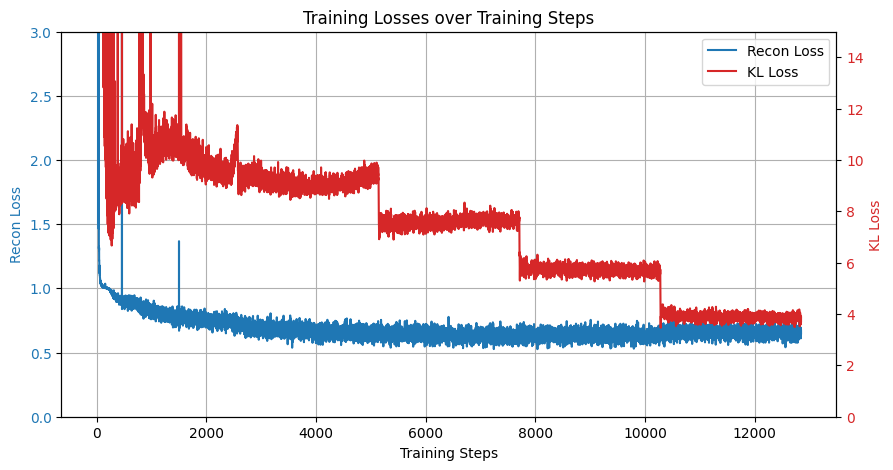

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Assume PyTorch Geometric is installed: pip install torch_geometric
from torch_geometric.nn import GATConv
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool,GlobalAttention
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse, add_self_loops, to_dense_batch, scatter
from torch_geometric.utils import to_dense_batch

# --- TCN Block ---
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout_rate):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=self.padding, dilation=dilation
        )
        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size,
            padding=self.padding, dilation=dilation
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        # Input shape: [B, C_in, T]
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = out[:, :, :x.shape[-1]]
        if self.residual_conv is not None:
            residual = self.residual_conv(residual)
        out = out + residual
        return out

# --- TCN Temporal Encoder ---
class TCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, kernel_size, dropout_rate):
        super().__init__()
        self.layers = nn.ModuleList()
        dilations = [2**i for i in range(num_layers)]  # Exponential dilation
        current_channels = in_channels
        for i in range(num_layers):
            self.layers.append(
                TCNBlock(
                    in_channels=current_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size,
                    dilation=dilations[i],
                    dropout_rate=dropout_rate
                )
            )
            current_channels = hidden_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 

# --- TCN Temporal Decoder ---
class TCNDecoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, kernel_size, dropout_rate):
        super().__init__()
        self.layers = nn.ModuleList()
        dilations = [2**i for i in range(num_layers)] # Exponential dilation
        current_channels = in_channels
        for i in range(num_layers):
            self.layers.append(
                TCNBlock( 
                    in_channels=current_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size,
                    dilation=dilations[i],
                    dropout_rate=dropout_rate
                )
            )
            current_channels = hidden_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class DelayEmbeddingTorch(nn.Module):

    def __init__(self, tau: int, M: int):
        super().__init__()
        self.tau = tau
        self.M = M

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, T = x.shape
        required_length = (self.M - 1) * self.tau + 1 # Minimum length needed for one vector
        W = T - (self.M - 1) * self.tau # New sequence length
        output = torch.zeros(B, C, self.M, W, device=x.device, dtype=x.dtype)
        for m in range(self.M):
            time_offset = m * self.tau
            output[:, :, m, :] = x[:, :, time_offset : time_offset + W]
        embedded_output = output.permute(0, 1, 2, 3).reshape(B, C * self.M, W)
        return embedded_output

# --- Reparameterization Trick ---
def reparameterize(z_mean, z_log_var, training):
    if not training: return z_mean
    std = torch.exp(0.5 * z_log_var)
    eps = torch.randn_like(std)
    return z_mean + eps * std

# --- Graph Variational Autoencoder ---
class GraphCVAE(nn.Module):

    def __init__(self, node_feature_dim, s_dim, u_dim,
                 coord_dim, coord_embed_dim, # Added coord params
                 temporal_hidden_dim, gnn_hidden_dim, 
                 latent_dim,num_timesteps,s_embed_dim=2,
                 teacher_forcing_ratio=0.5,num_temporal_layers=(2,2),
                 gat_heads=4, dropout_rate=0.1,
                 tau=2,M=20,kernel_size=(3,5),latent_network=True):
        super().__init__()

        self.subject_dim = s_dim
        self.subject_embedding_dim = s_embed_dim
        self.input_timeseries_dim = u_dim
        self.node_feature_dim = node_feature_dim
        self.coord_dim = coord_dim
        self.coord_embed_dim = coord_embed_dim
        self.temporal_hidden_dim = temporal_hidden_dim
        self.gnn_hidden_dim = gnn_hidden_dim
        self.num_timesteps = num_timesteps
        self.latent_dim = latent_dim
        self.num_temporal_layers = num_temporal_layers
        self.gat_heads = gat_heads
        self.dropout_rate = dropout_rate
        self.kernel_size = kernel_size
        self.latent_network = latent_network

        ### ENCODER ###

        # temporal encoders
        temp_encoder_input_dim = node_feature_dim #  + self.input_timeseries_dim #  + self.input_timeseries_dim #  + coord_embed_dim#  + 3  

        # Account for delay embedding
        self.use_dembed = tau > 0 and M > 1
        if self.use_dembed:
            temp_encoder_input_dim *= M
            self.delay_embedder = DelayEmbeddingTorch(tau=tau,M=M)
        else:
             self.delay_embedder = None # Explicitly set to None

        # Temporal Encoder
        self.temporal_encoder = TCNEncoder(
            in_channels=temp_encoder_input_dim,
            hidden_channels=self.temporal_hidden_dim[0],
            num_layers=self.num_temporal_layers[0],
            kernel_size=self.kernel_size[0],
            dropout_rate=self.dropout_rate # dropout_rate
        )

        # Condition/Coordinate Embedders
        self.c_embedder = nn.Sequential(
            nn.Linear(3*self.coord_dim, 2*self.coord_embed_dim),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(2*self.coord_embed_dim, self.coord_embed_dim) # Use self.num_classes
        )

        # graph neural network (spatial encoder)
        gnn_input_dim = 2*temporal_hidden_dim[0]  + coord_embed_dim  # 2*2*
        if self.gnn_hidden_dim[0] % self.gat_heads[0] != 0:
             self.gnn_hidden_dim[0] = (self.gnn_hidden_dim[0] // self.gat_heads[0]) * self.gat_heads[0]
        # self.encoder_gat1 = GATConv(gnn_input_dim, self.gnn_hidden_dim[0] // self.gat_heads[0],
        #                 heads=self.gat_heads[0], dropout=self.dropout_rate, concat=True)
        self.encoder_gat1 = GATv2Conv(gnn_input_dim, self.gnn_hidden_dim[0] // self.gat_heads[0],
                        heads=self.gat_heads[0], dropout=self.dropout_rate, concat=True)
       
        # VAE encoders
        vae_input_dim = self.gnn_hidden_dim[0] + 2*temporal_hidden_dim[0]# + coord_embed_dim#  + #  + 2*temporal_hidden_dim[0] 
        # 
        if self.latent_network:
            self.mean_pooling_layer = global_mean_pool
            self.max_pooling_layer = global_max_pool
            vae_input_dim *= 2

        self.fc_mean = nn.Linear(vae_input_dim, latent_dim)
        self.fc_log_var = nn.Linear(vae_input_dim, latent_dim)
        ### END ENCODER ###

        ### DECODER ###

        # GNN Decoder
        if self.gnn_hidden_dim[1] > 0:
            gnn_input_dim = latent_dim + coord_embed_dim #self.static_feature_dim
            if self.gnn_hidden_dim[1] % self.gat_heads[1] != 0:
                self.gnn_hidden_dim[1] = ( self.gnn_hidden_dim[1] // self.gat_heads[1]) * self.gat_heads[1]
            # self.decoder_gat1 = GATConv(gnn_input_dim,
            #                             self.gnn_hidden_dim[1] // self.gat_heads[1],
            #                             heads=self.gat_heads[1], concat=True,
            #                             dropout=self.dropout_rate)
            self.decoder_gat1 = GATv2Conv(gnn_input_dim,
                            self.gnn_hidden_dim[1] // self.gat_heads[1],
                            heads=self.gat_heads[1], concat=True,
                            dropout=self.dropout_rate)

            tcn_decoder_in_channels =  self.gnn_hidden_dim[1] # Input is now spatially-aware features
        else:
            self.static_feature_dim = 32
            static_projector_input_dim = latent_dim + coord_embed_dim # + self.s_embed_dim if used
            self.static_projector = nn.Sequential(
                nn.Linear(static_projector_input_dim,2*self.static_feature_dim),
                nn.ReLU(),
                nn.Dropout(self.dropout_rate),
                nn.Linear(self.static_feature_dim*2,self.static_feature_dim)
            )
            tcn_decoder_in_channels = self.static_feature_dim #self.static_feature_dim#  + latent_dim # + latent_dim # self.static_feature_dim

        # TCN Decoder
        self.tcn_decoder = TCNDecoder(
            in_channels=tcn_decoder_in_channels,
            hidden_channels= self.temporal_hidden_dim[1],
            num_layers=self.num_temporal_layers[1],
            kernel_size=self.kernel_size[1], # Use same kernel size? Or could be different
            dropout_rate=self.dropout_rate
        )

        # MLP output layer
        output_mapper_in_dim = self.temporal_hidden_dim[1] #  + self.static_feature_dim
        self.output_mapper = nn.Sequential(
            nn.Linear(output_mapper_in_dim, self.temporal_hidden_dim[1]*2),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.temporal_hidden_dim[1]*2,node_feature_dim)
        )
        ### END DECODER ###

    def encode(self,data,c): # ,s,u
        # extract graph data
        x, edge_index, batch, pos = data.x, data.edge_index, data.batch, data.pos
        # u = u.squeeze(1)
        c = c.squeeze(1)

        # --- Temporal Encoding ---
        temporal_input = x # torch.cat([x,u[batch]],dim=2) # add u to each node's timeseries
        if self.use_dembed:
            temporal_input = self.delay_embedder(temporal_input.permute(0, 2, 1)).permute(0, 2, 1)

        temporal_input = temporal_input.permute(0, 2, 1)  # [total_nodes, C, T]
        temporal_output = self.temporal_encoder(temporal_input) # [total_nodes, layers*2*hidden]
        node_embeddings_temporal = temporal_output[:, :, -1]  # [total_nodes, temporal_hidden_dim]
        node_embeddings_max = F.adaptive_max_pool1d(temporal_output, 1).squeeze(-1)
        node_embeddings_avg = F.adaptive_avg_pool1d(temporal_output, 1).squeeze(-1)
        node_embeddings_temporal = torch.cat((node_embeddings_max, node_embeddings_avg), dim=1)

        # --- Spatial Encoding ---
        c_embed_input = torch.cat([pos,c[batch]],dim=1)
        coord_embeddings = self.c_embedder(c_embed_input)
        # gnn_input_features = node_embeddings_temporal #torch.cat([node_embeddings_temporal,coord_embeddings],dim=1)
        gnn_input_features = torch.cat([node_embeddings_temporal,coord_embeddings],dim=1)
        gnn_input_features = torch.cat([node_embeddings_temporal,coord_embeddings],dim=1)
        node_embeddings_spatial = self.encoder_gat1(gnn_input_features,edge_index)
        # node_embeddings = torch.cat([node_embeddings_spatial,coord_embeddings],dim=1) # torch.cat([node_embeddings_spatial,node_embeddings_temporal],dim=1)
        node_embeddings = torch.cat([node_embeddings_spatial,node_embeddings_temporal],dim=1) # node_embeddings_temporal torch.cat([node_embeddings_spatial,node_embeddings_temporal],dim=1)

        # get a network latent average if enabled
        if self.latent_network:
            node_embeddings_mean = self.mean_pooling_layer(node_embeddings, batch)
            node_embeddings_max = self.max_pooling_layer(node_embeddings, batch)
            node_embeddings = torch.cat([node_embeddings_mean,node_embeddings_max],dim=1)

        # Apply fc_mean and fc_log_var directly to node/graph embeddings
        z_mean_nodes = self.fc_mean(node_embeddings)     # Shape: [N, latent_dim]
        z_log_var_nodes = self.fc_log_var(node_embeddings) # Shape: [N, latent_dim]

        # Return distributions
        return z_mean_nodes, z_log_var_nodes
    
    def decode(self,z,c,data): # s,u,
        z = z.squeeze(1) if z.dim() == 3 else z
        c = c.squeeze(1) if c.dim() == 3 else c
    
        batch = data.batch
        node_coords = data.pos
        edge_index = data.edge_index # Get edge_index

        # Stim Coordinate Embeddings
        c_embed_input = torch.cat([node_coords,c[batch]],dim=1)
        coord_embeddings = self.c_embedder(c_embed_input)

        # Distribute latent variable z to nodes
        if self.latent_network:
            z_node = z[batch]
        else:
            z_node = z

        # GAT Decoder
        if self.gnn_hidden_dim[1] > 0:
            static_features = torch.cat([z_node,coord_embeddings],dim=1)
            spatial_features = self.decoder_gat1(static_features, edge_index)
            decoder_input_seq = spatial_features.unsqueeze(1).repeat(1,self.num_timesteps,1) 
        else:
            static_features_in = torch.cat([z_node,coord_embeddings],dim=1)
            static_features = self.static_projector(static_features_in)
            decoder_input_seq = static_features.unsqueeze(1).repeat(1,self.num_timesteps,1)

        #  TCN Decoder
        tcn_input = decoder_input_seq.permute(0, 2, 1)
        tcn_output = self.tcn_decoder(tcn_input) 
        output = tcn_output.permute(0, 2, 1)
        x_recon = self.output_mapper(output) 
        return x_recon

    def forward(self, data, c):  #  ,s, u
        z_mean, z_log_var = self.encode(data, c) # , s, u
        z = reparameterize(z_mean, z_log_var, self.training)
        x_recon = self.decode(z, c,  data) # s, u,
        return x_recon, z_mean, z_log_var, z

    def loss_function(self, x_recon, x_original, z_mean, z_log_var, beta=1.0):
        recon_loss = F.mse_loss(x_recon.view(-1, self.node_feature_dim),x_original.view(-1, self.node_feature_dim),reduction='mean')
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), dim=1)
        kl_loss = torch.mean(kl_loss)
        vae_loss = recon_loss + beta * kl_loss
        return vae_loss, recon_loss, kl_loss

def validate_graph_cvae(loader, vae_model, beta, device):

    vae_model.eval()  # Set model to evaluation mode
    total_vae_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    num_batches = 0

    with torch.no_grad(): 
        for data_batch in loader:
            data_batch = data_batch.to(device)
            condition_batch = data_batch.condition
            # s_batch = data_batch.s_condition
            # u_batch = data_batch.u_condition

            x_recon, z_mean, z_log_var, z = vae_model(data_batch,condition_batch) # ,s_batch,u_batch)
            loss_vae, loss_recon, loss_kl = vae_model.loss_function(
                x_recon, data_batch.x, z_mean, z_log_var, beta
            )
            
            total_vae_loss += loss_vae.item()
            total_recon_loss += loss_recon.item()
            total_kl_loss += loss_kl.item()
            num_batches += 1
    
    if num_batches > 0:
        avg_vae_loss = total_vae_loss / num_batches
        avg_recon_loss = total_recon_loss / num_batches
        avg_kl_loss = total_kl_loss / num_batches
        return avg_vae_loss, avg_recon_loss, avg_kl_loss
    else:
        return None, None, None

def train_graph_cvae(epochs,train_loader,vae_model,optimizer_vae,device,val_loader=None,
                     anneal_epochs=0,beta_start=1e-3,beta_final=1):

    from tqdm.auto import tqdm # Import tqdm
    
    vae_model.to(device)

    if anneal_epochs > 0:
        anneal_betas = np.logspace(beta_start,beta_final,anneal_epochs)
        print(anneal_betas)

    # Initialize lists to log loss history
    all_recon_losses = []
    all_kl_losses = []
    all_betas = [] # To track beta value
    for epoch in range(1, epochs + 1):
        vae_model.train()

        # --- Calculate current beta for annealing ---
        if anneal_epochs > 0:
            current_beta = anneal_betas[int(epoch-1)]
        else:
            current_beta = beta_final

        all_betas.append(current_beta) # Log current beta

        epoch_losses = {'vae_total': 0, 'recon': 0, 'kl': 0, 'adv': 0, 'fool': 0}
        batch_count = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}, Beta {current_beta:.2e}", leave=True, unit="batch")
        for data_batch in pbar:
            # , condition_batch,_,s_batch,u_batch in
            batch_count += 1
            data_batch = data_batch.to(device)
            condition_batch = data_batch.condition
            # s_batch = data_batch.s_condition
            # u_batch = data_batch.u_condition

            # --- Train VAE ---
            optimizer_vae.zero_grad()
            original_x = data_batch.x

            # VAE forward pass
            x_recon, z_mean, z_log_var, z = vae_model(data_batch,condition_batch) # ,s_batch,u_batch

            # VAE loss
            loss_total_vae_train, loss_recon, loss_kl = vae_model.loss_function(
                x_recon, original_x, z_mean, z_log_var, current_beta 
            )
            loss_total_vae_train.backward()
            torch.nn.utils.clip_grad_norm_(vae_model.parameters(), max_norm=10.0) 
            optimizer_vae.step()


            # --- Accumulate standard VAE losses ---
            epoch_losses['vae_total'] += loss_total_vae_train.item()
            epoch_losses['recon'] += loss_recon.item()
            epoch_losses['kl'] += loss_kl.item()

            # Log per-batch losses
            all_recon_losses.append(loss_recon.item())
            all_kl_losses.append(loss_kl.item())
            postfix_dict = {"VAE": f"{loss_total_vae_train.item():.3f}", "Recon": f"{loss_recon.item():.3f}", "KL": f"{loss_kl.item():.3f}"}
            pbar.set_postfix(postfix_dict)

        # --- Log epoch results ---
        num_batches = batch_count
        if num_batches > 0:
            log_msg = (f"Epoch: {epoch:03d}/{epochs} | "
                       f"VAE Loss: {epoch_losses['vae_total']/num_batches:.4f} "
                       f"(Recon: {epoch_losses['recon']/num_batches:.4f}, KL: {epoch_losses['kl']/num_batches:.4f}) "
                       f"(Beta: {current_beta}")
            print(log_msg)
        else:
             print(f"Epoch: {epoch:03d}/{epochs} | No batches processed.")

        # Validation Step
        if val_loader is not None:
            val_losses = validate_graph_cvae(val_loader, vae_model, current_beta, device)
            if val_losses[0] is not None:
                print(f"Validation - VAE Loss: {val_losses[0]:.4f} "
                      f"(Recon: {val_losses[1]:.4f}, KL: {val_losses[2]:.4f})")

    # Return the loss history
    return all_recon_losses, all_kl_losses

# model params
COORD_EMBED_DIM = 4 #  4
GNN_HIDDEN = (32,0) #  16
LATENT_DIM = 8
GAT_HEADS = (4,0)# 4
TEMPORAL_HIDDEN = (16,16)  # // 2
NUM_TIME_LAYERS = (7,7)
TEMP_KERNEL_SIZE = (3,3)
DEMBED_TAU = 2
DEMBED_M = 30
LATENT_NETWORK = False

# training params
EPOCHS = 5  # 
BETA_START = -3 # 1e-1 # 1e-5 # 1.0
BETA_END = -1 # 1e-1 # 1e-5 # 1.0
ANNEAL_EPOCHS = EPOCHS + int(EPOCHS/2)
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-3
DROPOUT_RATE = 0.5 # 3

# --- Instantiate Models ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
vae_model = GraphCVAE(
    node_feature_dim=NODE_FEAT_DIM,s_dim=2,u_dim=2,
    coord_dim=COORD_DIM,coord_embed_dim=COORD_EMBED_DIM,
    temporal_hidden_dim=TEMPORAL_HIDDEN, gnn_hidden_dim=GNN_HIDDEN,latent_dim=LATENT_DIM,
    num_timesteps=NUM_TIMESTEPS,
    num_temporal_layers=NUM_TIME_LAYERS,gat_heads=GAT_HEADS,dropout_rate=DROPOUT_RATE,
    tau=DEMBED_TAU,M=DEMBED_M,kernel_size=TEMP_KERNEL_SIZE,latent_network=LATENT_NETWORK
)

# --- VAE Optimizer ---
optimizer_vae = optim.Adam(vae_model.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)# 1e-4)

# --- Run Training ---
recon_losses, kl_losses = train_graph_cvae(
    epochs=EPOCHS,
    train_loader=train_all_loader,
    val_loader=val_loader,
    vae_model=vae_model,
    optimizer_vae=optimizer_vae,
    device=DEVICE,
    beta_start=BETA_START,
    beta_final=BETA_END,
    anneal_epochs=ANNEAL_EPOCHS
)

plt.figure(figsize=(10, 5))

# Primary axis for Reconstruction Loss
ax1 = plt.gca()
line1, = ax1.plot(recon_losses, label='Recon Loss', color='tab:blue')
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Recon Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim([0, 3])
ax1.grid(True)

ax2 = ax1.twinx()
line2, = ax2.plot(kl_losses, label='KL Loss', color='tab:red')
ax2.set_ylabel('KL Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim([0, 15])
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title('Training Losses over Training Steps')
plt.show()


### Visualization

Generating Latent Embeddings:   0%|          | 0/882 [00:00<?, ?it/s]

Generating Latent Embeddings:   0%|          | 0/239 [00:00<?, ?it/s]

Generating Latent Embeddings:   0%|          | 0/240 [00:00<?, ?it/s]

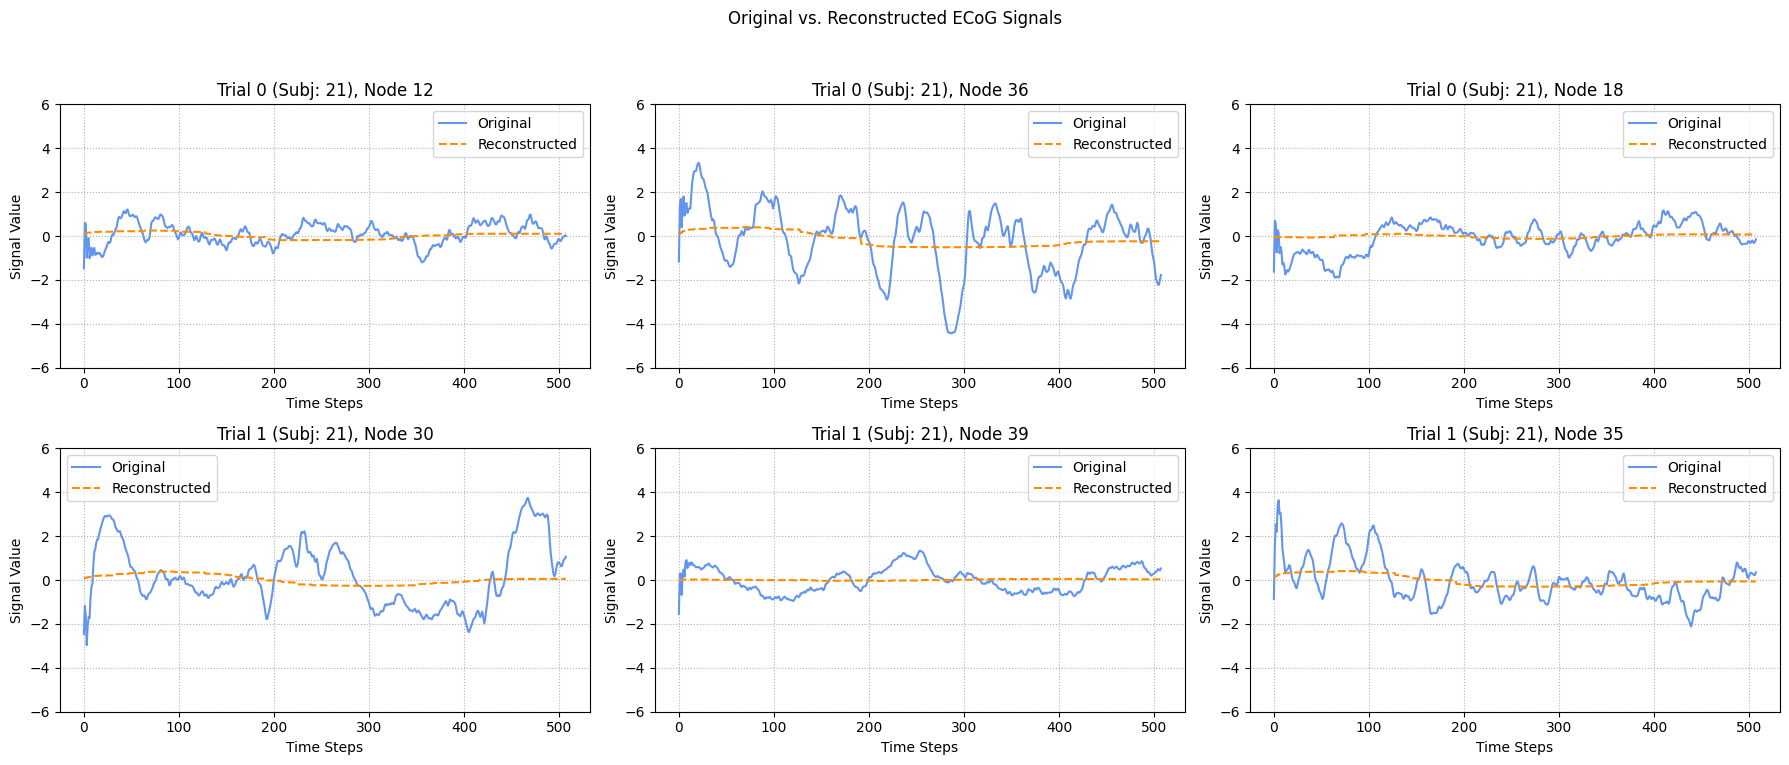

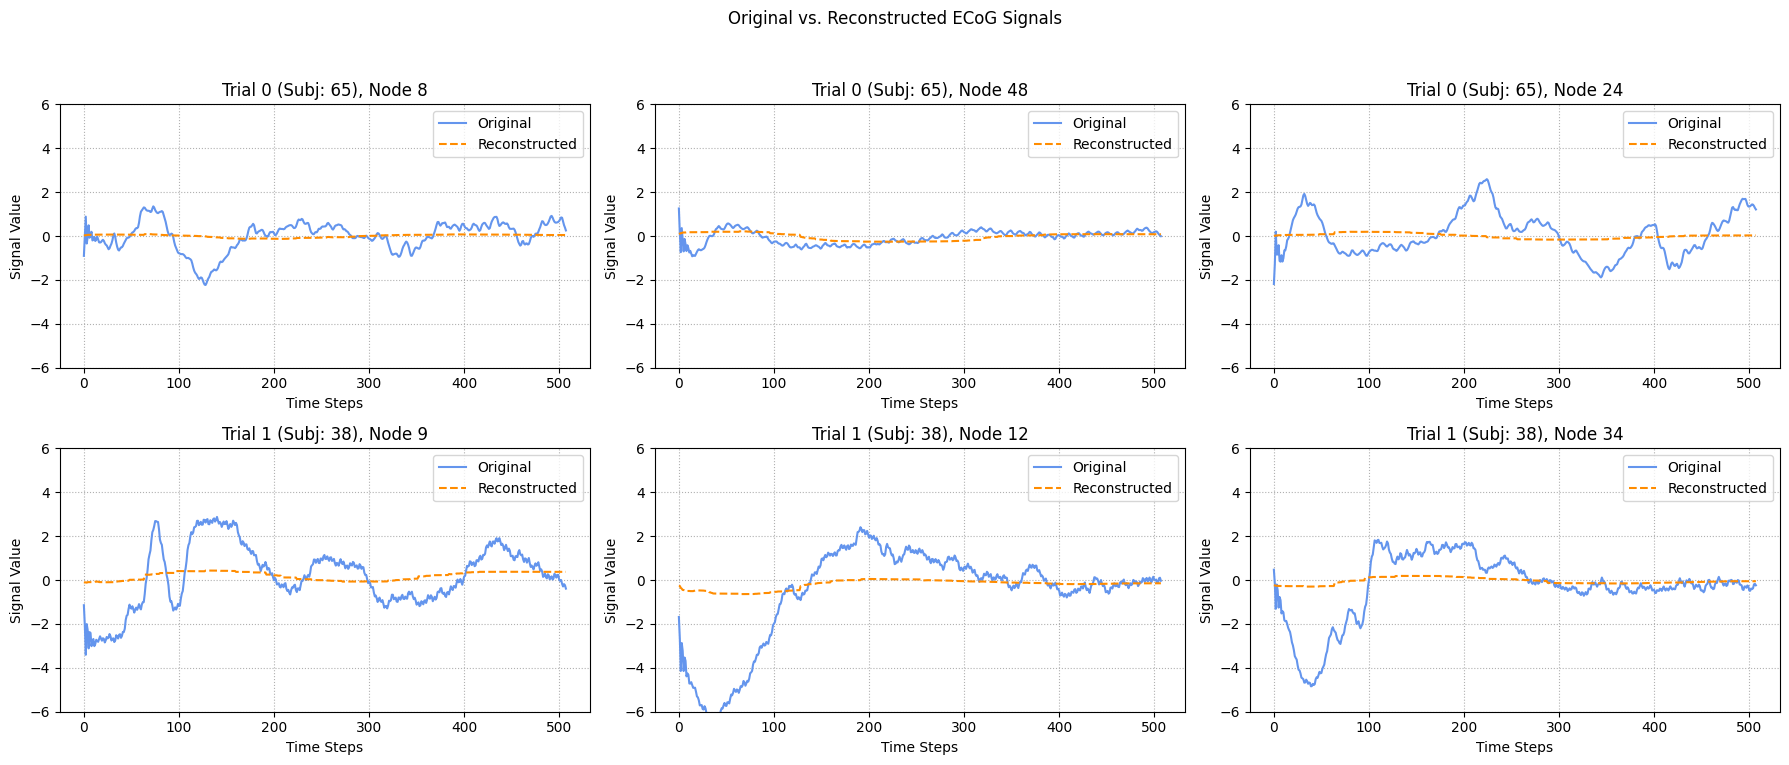

In [17]:
import matplotlib.pyplot as plt
import random

# # Get embeddings and corresponding subject IDs for the validation set
def get_all_latent_embeddings(loader, vae_model, device):
    from tqdm.auto import tqdm
    vae_model.eval() # Set model to evaluation mode
    vae_model.to(device)
    all_z_means = []
    all_subject_ids = []
    all_labels = []
    with torch.no_grad():
        for data_batch in tqdm(loader, desc="Generating Latent Embeddings", leave=False):
            data_batch = data_batch.to(device)
            batch_vector = data_batch.batch
            condition_batch = data_batch.condition
            subject_id_batch = data_batch.subject_id
            z_mean, _ = vae_model.encode(data_batch, condition_batch)
            all_z_means.append(z_mean.cpu())
            if vae_model.latent_network:
                all_subject_ids.extend(subject_id_batch.cpu().numpy())
            else:
                all_subject_ids.extend(subject_id_batch[batch_vector].cpu().numpy())
            all_labels.extend(data_batch.y.cpu().numpy())

    if not all_z_means:
        return None, None

    all_z_means_cat = torch.cat(all_z_means, dim=0)
    return all_z_means_cat, all_subject_ids, np.array(all_labels)

train_z_means, train_subject_ids_collected,train_y_labels = get_all_latent_embeddings(train_l_loader, vae_model, DEVICE)
val_z_means, val_subject_ids_collected,val_y_labels = get_all_latent_embeddings(val_loader, vae_model, DEVICE)
test_z_means, test_subject_ids_collected,test_y_labels = get_all_latent_embeddings(test_loader, vae_model, DEVICE)

# --- Plot Reconstructions ---
def plot_reconstruction_examples(vae_model, loader, device, num_examples=2, nodes_per_example=2, node_feature_index=0):
    vae_model.eval()
    vae_model.to(device)
    data_batch = next(iter(loader)) 
    data_batch = data_batch.to(device)
    condition_batch = data_batch.condition
    subject_ids_batch = data_batch.subject_id

    with torch.no_grad():
        x_recon, z_mean, z_log_var, z = vae_model(data_batch, condition_batch)

    original_x_dense, mask = to_dense_batch(data_batch.x, data_batch.batch)
    recon_x_dense, _ = to_dense_batch(x_recon, data_batch.batch)

    batch_size = original_x_dense.shape[0]
    num_timesteps = original_x_dense.shape[2]
    time_axis = np.arange(num_timesteps)

    plot_count = 0
    num_rows = num_examples
    num_cols = nodes_per_example
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows), squeeze=False)
    fig.suptitle("Original vs. Reconstructed ECoG Signals")

    for i in range(min(num_examples, batch_size)): 
        num_nodes_in_graph = int(mask[i].sum())
        if num_nodes_in_graph == 0: continue
        # Select random nodes to plot for this trial
        node_indices = random.sample(range(num_nodes_in_graph), min(nodes_per_example, num_nodes_in_graph))
        for j_idx, node_idx in enumerate(node_indices):
            if plot_count >= num_rows * num_cols: break 
            ax = axes[i, j_idx] 
            original_ts = original_x_dense[i, node_idx, :, node_feature_index].cpu().numpy()
            recon_ts = recon_x_dense[i, node_idx, :, node_feature_index].cpu().numpy()
            ax.plot(time_axis, original_ts, label='Original', color='cornflowerblue', linewidth=1.5)
            ax.plot(time_axis, recon_ts, label='Reconstructed', color='darkorange', linestyle='--', linewidth=1.5)
            ax.set_title(f"Trial {i} (Subj: {subject_ids_batch[i]}), Node {node_idx}")
            ax.set_xlabel("Time Steps")
            ax.set_ylabel("Signal Value")
            ax.set_ylim([-6,6])
            ax.legend()
            ax.grid(True, linestyle=':')
            plot_count += 1
        if plot_count >= num_rows * num_cols: break

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
    plt.show()

# Use validation loader for examples
plot_reconstruction_examples(vae_model, val_loader, DEVICE, num_examples=2, nodes_per_example=3)
plot_reconstruction_examples(vae_model, train_l_loader, DEVICE, num_examples=2, nodes_per_example=3)



--- Plotting SOZ (Categorical) ---
Randomly sampling 43520/870404 points (5.0%) for processing and plotting...
Reducing 8 dimensions to 2 on 43520 samples...
Fitting and transforming the subset...


c:\Users\tyler_p5hze3w\anaconda3\envs\park_dynamics\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tyler_p5hze3w\anaconda3\envs\park_dynamics\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Plotting 43520 points across 22 unique subjects...


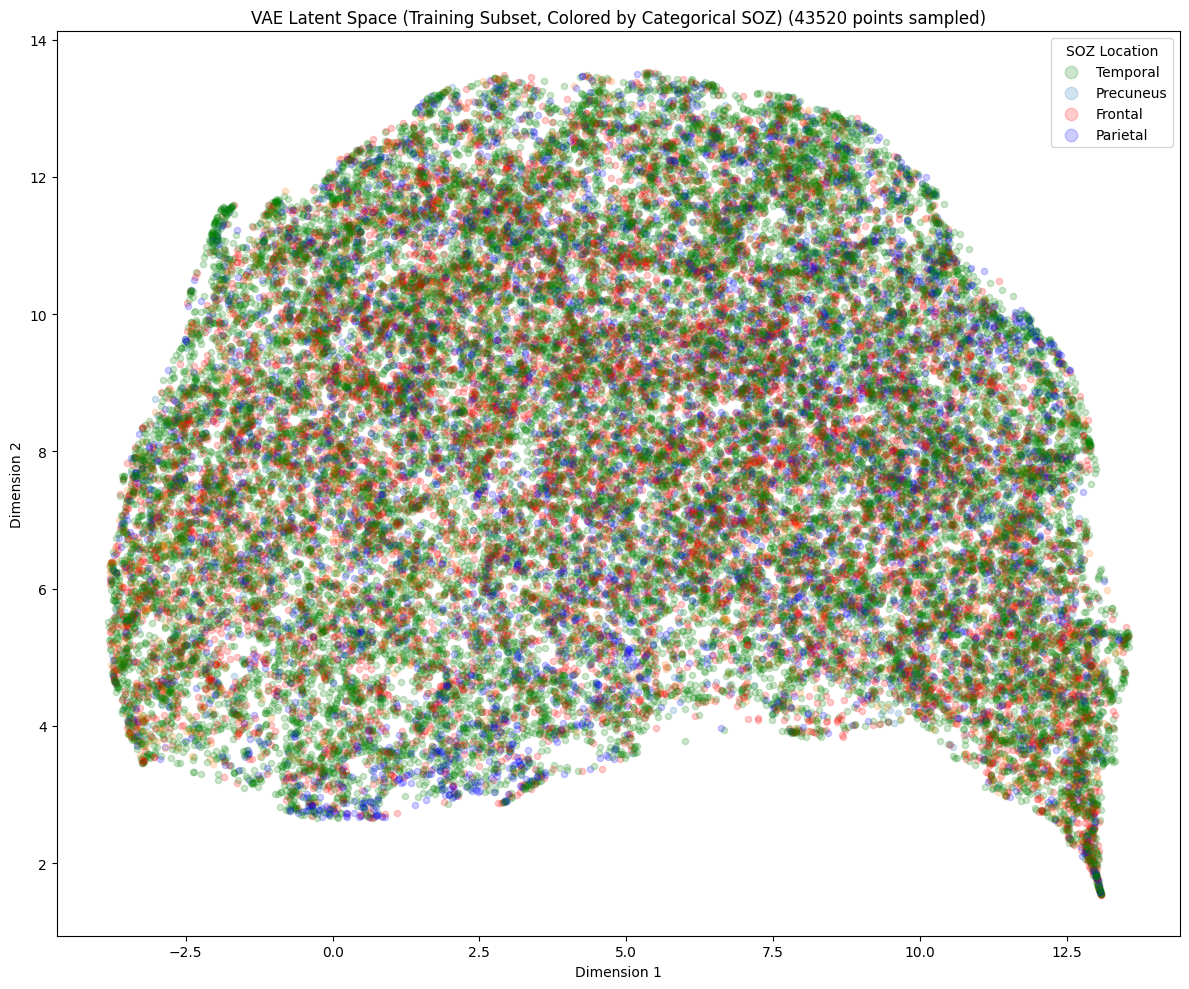

Randomly sampling 9597/191954 points (5.0%) for processing and plotting...
Reducing 8 dimensions to 2 on 9597 samples...
Transforming the subset using the provided reducer model...


c:\Users\tyler_p5hze3w\anaconda3\envs\park_dynamics\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Plotting 9597 points across 7 unique subjects...


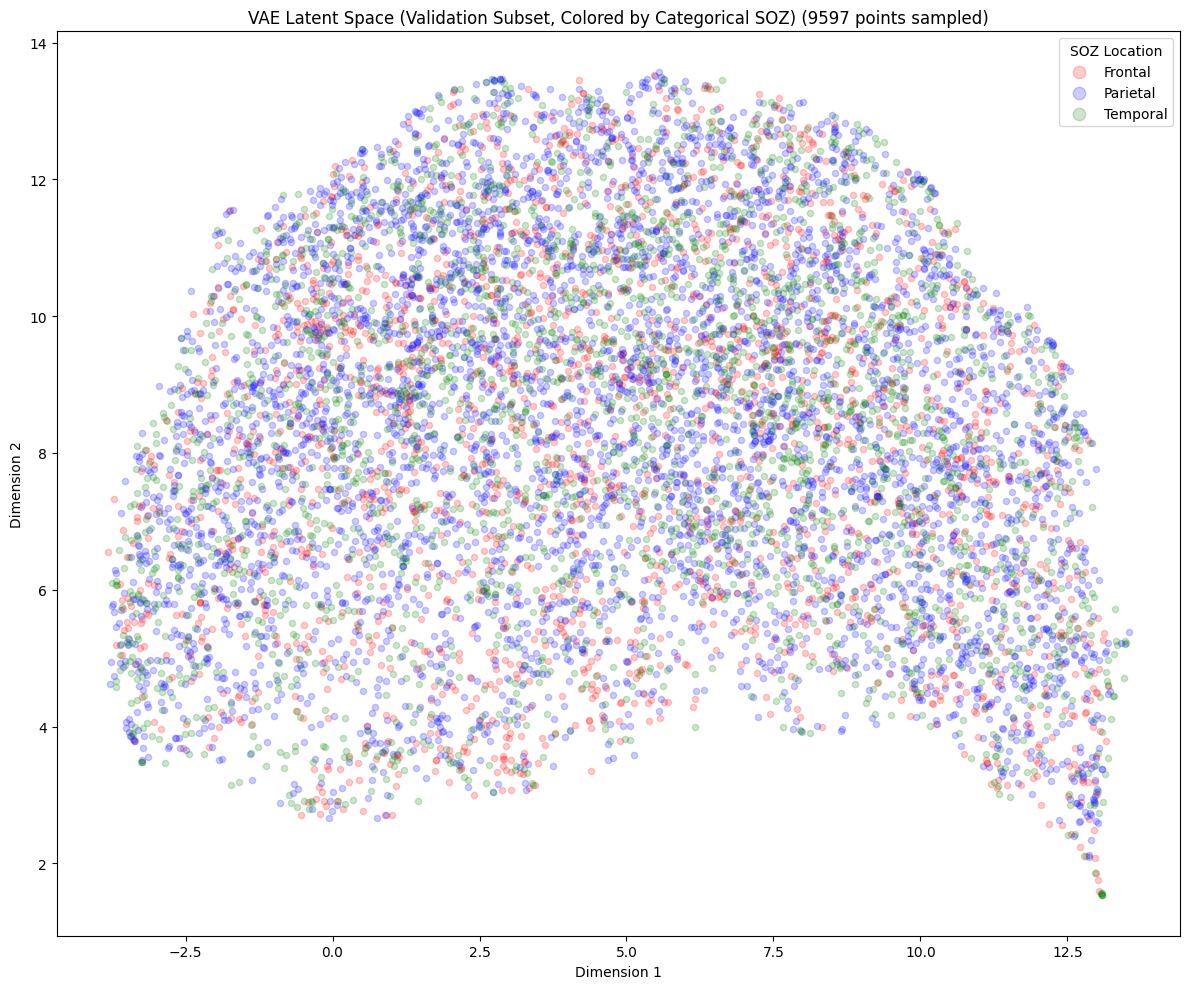

Randomly sampling 12309/246195 points (5.0%) for processing and plotting...
Reducing 8 dimensions to 2 on 12309 samples...
Transforming the subset using the provided reducer model...


c:\Users\tyler_p5hze3w\anaconda3\envs\park_dynamics\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Plotting 12309 points across 7 unique subjects...


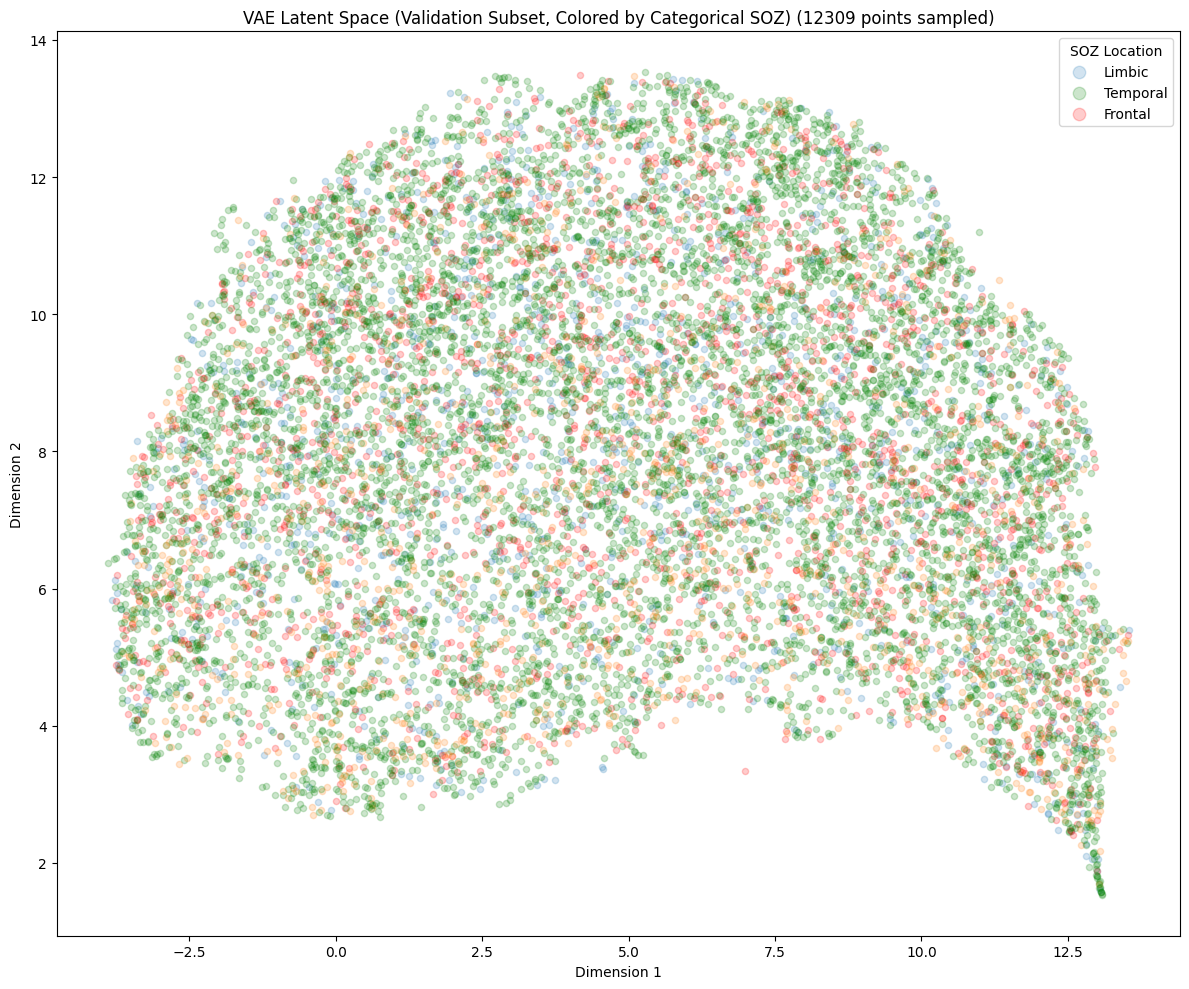

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import random # Ensure random is imported

def plot_latent_space_soz(z_embedded, y_label, title="Latent Space Visualization",
                          max_dims=2, reducer_model=None,
                          plot_percentage=1.0, random_state=42): # Added plot_percentage and random_state

    # Ensure inputs are numpy arrays
    z_embedded = np.asarray(z_embedded)
    y_label = np.asarray(y_label)

    n_total_samples = z_embedded.shape[0]
    n_dims = z_embedded.shape[1]

    if n_total_samples == 0:
        print("Warning: No data provided to plot.")
        return None
    if len(y_label) != n_total_samples:
        raise ValueError("Length of z_embedded and y_label must match.")
    if n_dims < 2:
        raise ValueError("z_embedded must have at least 2 dimensions for plotting")

    # --- Random Sampling ---
    np.random.seed(random_state) # Set seed for sampling reproducibility
    plot_percentage = np.clip(plot_percentage, 0.0, 1.0)
    num_plot_samples = int(n_total_samples * plot_percentage)

    if num_plot_samples == 0 and plot_percentage > 0:
         num_plot_samples = 1
    elif num_plot_samples == 0:
         print("Warning: Plot percentage resulted in 0 samples. Nothing to plot.")
         return reducer_model

    if num_plot_samples < n_total_samples:
        print(f"Randomly sampling {num_plot_samples}/{n_total_samples} points ({plot_percentage*100:.1f}%) for processing and plotting...")
        indices_to_plot = np.random.choice(n_total_samples, num_plot_samples, replace=False)
        z_subset = z_embedded[indices_to_plot]
        y_plot = y_label[indices_to_plot] # Use y_plot for labels corresponding to z_subset/z_plot
    else:
        print("Processing and plotting all samples...")
        z_subset = z_embedded
        y_plot = y_label
        num_plot_samples = n_total_samples # Ensure count is correct
    # --- End Sampling ---

    # Apply dimensionality reduction *on the subset*
    z_plot = z_subset # Start with the subset
    current_subset_dims = z_subset.shape[1]

    if current_subset_dims > max_dims:
        print(f"Reducing {current_subset_dims} dimensions to {max_dims} on {num_plot_samples} samples...")
        if reducer_model is None:
            print("Fitting and transforming the subset...")
            if current_subset_dims > 3: # Prefer UMAP for higher dimensions
                reducer_model = umap.UMAP(n_components=max_dims, random_state=random_state)
            else: # Use PCA for lower dimensions
                reducer_model = PCA(n_components=max_dims)
            # Fit and transform the subset
            z_plot = reducer_model.fit_transform(z_subset)
        else:
            print("Transforming the subset using the provided reducer model...")
            # Only transform the subset using the pre-fitted model
            z_plot = reducer_model.transform(z_subset)
    elif current_subset_dims != max_dims:
        # If dims are <= max_dims but not equal, just take the first max_dims
        print(f"Warning: Subset dimension {current_subset_dims} does not match max_dims {max_dims}. Using first {max_dims} dimensions.")
        z_plot = z_subset[:, :max_dims]


    # Create figure
    fig = plt.figure(figsize=(12, 10))
    plot_dims_final = z_plot.shape[1]
    if plot_dims_final == 2:
        ax = fig.add_subplot(111)  # 2D plot
    elif plot_dims_final == 3:
        ax = fig.add_subplot(111, projection='3d')  # 3D plot
    else:
        raise ValueError(f"Data to plot must end up with 2 or 3 dimensions, but got {plot_dims_final}")

    # Get indices for each class within the sampled data (y_plot)
    soz_1_idx = np.where(y_plot == 1)[0]
    soz_0_idx = np.where(y_plot == 0)[0]

    # Create Scatter plot
    scatter_alpha = max(0.2, min(1.0, 0.5 / np.sqrt(num_plot_samples/1000)))
    scatter_size = max(5, min(50, 50 / np.sqrt(num_plot_samples/1000)))

    if plot_dims_final == 3:
        if len(soz_1_idx) > 0:
            ax.scatter(z_plot[soz_1_idx, 0], z_plot[soz_1_idx, 1], z_plot[soz_1_idx, 2], color='orange', label=f'SOZ (n={len(soz_1_idx)})', alpha=scatter_alpha, s=scatter_size)
        if len(soz_0_idx) > 0:
            ax.scatter(z_plot[soz_0_idx, 0], z_plot[soz_0_idx, 1], z_plot[soz_0_idx, 2], color='blue', label=f'Non-SOZ (n={len(soz_0_idx)})', alpha=scatter_alpha, s=scatter_size)
        ax.set_zlabel("Dimension 3")
    else: # 2D plot
        if len(soz_1_idx) > 0:
            ax.scatter(z_plot[soz_1_idx, 0], z_plot[soz_1_idx, 1], color='orange', label=f'SOZ (n={len(soz_1_idx)})', alpha=scatter_alpha, s=scatter_size)
        if len(soz_0_idx) > 0:
            ax.scatter(z_plot[soz_0_idx, 0], z_plot[soz_0_idx, 1], color='blue', label=f'Non-SOZ (n={len(soz_0_idx)})', alpha=scatter_alpha, s=scatter_size)

    # Set labels and title
    ax.set_title(f"{title} ({num_plot_samples} points sampled)")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    ax.legend(markerscale=2)
    plt.tight_layout()
    plt.show()

    # Return the reducer model (either newly fitted or the one passed in)
    return reducer_model


# --- Define helper to generate colormap ---
def generate_dynamic_colormap(categories, cmap_name='tab10', fallback_color='#7f7f7f'):

    import matplotlib.cm as cm # Import colormap functionality

    unique_categories = sorted(list(set(categories)))
    num_categories = len(unique_categories)
    
    # Get the colormap
    try:
        colormap = cm.get_cmap(cmap_name, num_categories)
    except ValueError:
        print(f"Warning: Colormap '{cmap_name}' not found or doesn't support N={num_categories}. Falling back to 'viridis'.")
        colormap = cm.get_cmap('viridis', num_categories)

    # Generate colors, handling specific categories
    category_to_color = {}
    color_index = 0
    standard_categories = []

    # Prioritize specific categories if they exist
    for cat in unique_categories:
        if cat in ['Unknown', 'Other', 'Mixed']:
             # Assign fallback color directly
             category_to_color[cat] = fallback_color
        else:
             standard_categories.append(cat) # Collect standard categories

    # Assign colors from colormap to standard categories
    num_standard = len(standard_categories)
    try:
        standard_colormap = cm.get_cmap(cmap_name, max(1, num_standard)) # Ensure at least 1 color if only special cats exist
    except ValueError:
        standard_colormap = cm.get_cmap('viridis', max(1, num_standard))

    for i, cat in enumerate(standard_categories):
         # Convert RGBA tuple (0-1 range) to hex
         rgba_color = standard_colormap(i / max(1, num_standard -1) if num_standard > 1 else 0.5) # Normalize index
         hex_color = plt.matplotlib.colors.to_hex(rgba_color)
         category_to_color[cat] = hex_color

    # Ensure all original categories are covered (handles case if only special categories exist)
    for cat in unique_categories:
        if cat not in category_to_color:
             print(f"Warning: Category '{cat}' missed initial assignment, using fallback.")
             category_to_color[cat] = fallback_color


    return category_to_color


# --- Helper function using Seaborn Palettes ---
def generate_dynamic_colormap_seaborn(categories, cmap_name='Set2', fallback_color='#888888'): # Darker fallback
    unique_categories = sorted(list(set(categories)))
    fallback_cats = ['Unknown', 'Other', 'Mixed'] # Categories to get fallback color
    category_to_color = {}

    # Separate standard categories from fallback categories
    standard_categories = [cat for cat in unique_categories if cat not in fallback_cats]
    num_standard = len(standard_categories)

    # Assign fallback colors first
    for cat in unique_categories:
        if cat in fallback_cats:
            category_to_color[cat] = fallback_color

    # Generate and assign colors for standard categories
    if num_standard > 0:
        try:
            # Use n_colors to get the exact number needed from seaborn
            palette = sns.color_palette(cmap_name, n_colors=num_standard)
            hex_colors = palette.as_hex()
        except Exception as e:
            # Fallback if the palette name is invalid or causes issues
            print(f"Warning: Failed to get Seaborn palette '{cmap_name}' with {num_standard} colors. Error: {e}. Falling back to 'husl'.")
            palette = sns.color_palette("husl", n_colors=num_standard)
            hex_colors = palette.as_hex()

        # Handle cases where palette might return fewer colors than requested (e.g., 'Set1' max 9)
        if len(hex_colors) < num_standard:
             print(f"Warning: Palette '{cmap_name}' returned fewer colors ({len(hex_colors)}) than needed ({num_standard}). Colors will repeat/cycle.")
             from itertools import cycle
             color_cycle = cycle(hex_colors)
             # Assign colors by cycling
             for cat in standard_categories:
                  category_to_color[cat] = next(color_cycle)
        else:
             # Assign colors directly
             for i, cat in enumerate(standard_categories):
                  category_to_color[cat] = hex_colors[i]

    # Final check to ensure all categories got a color
    for cat in unique_categories:
        if cat not in category_to_color:
            print(f"Warning: Category '{cat}' missed assignment, using fallback.")
            category_to_color[cat] = fallback_color

    return category_to_color


def plot_latent_space_cat_soz(z_embedded, subject_ids, subject_soz_info, title="Latent Space Visualization",
                              max_dims=2, reducer_model=None,
                              plot_percentage=1.0, random_state=42): # Added plot_percentage and random_state

    # define Lobe Colors
    coarse_colormap = {
        'Frontal': 'red',
        'Parietal': 'blue',
        'Temporal': 'green',
        'Occipital': 'purple',
        'Limbic/Cingulate': 'orange',
        'Insula': 'cyan',
        'Unknown/Subcortical': 'grey',
        'Unknown': '#7f7f7f',
        'Outside Atlas': 'black' 
    }
    # Ensure inputs are numpy arrays
    z_embedded = np.asarray(z_embedded)
    subject_ids = np.asarray(subject_ids)

    n_total_samples = z_embedded.shape[0]
    n_dims = z_embedded.shape[1]

    # --- Random Sampling ---
    np.random.seed(random_state)
    plot_percentage = np.clip(plot_percentage, 0.0, 1.0)
    num_plot_samples = int(n_total_samples * plot_percentage)

    if num_plot_samples == 0 and plot_percentage > 0:
         num_plot_samples = 1
    elif num_plot_samples == 0:
         print("Warning: Plot percentage resulted in 0 samples. Nothing to plot.")
         return reducer_model

    if num_plot_samples < n_total_samples:
        print(f"Randomly sampling {num_plot_samples}/{n_total_samples} points ({plot_percentage*100:.1f}%) for processing and plotting...")
        indices_to_plot = np.random.choice(n_total_samples, num_plot_samples, replace=False)
        z_subset = z_embedded[indices_to_plot]
        subject_ids_plot = subject_ids[indices_to_plot] 
    else:
        print("Processing and plotting all samples...")
        z_subset = z_embedded
        subject_ids_plot = subject_ids
        num_plot_samples = n_total_samples 

    # Apply dimensionality reduction *on the subset*
    z_plot = z_subset # Start with the subset
    current_subset_dims = z_subset.shape[1]

    if current_subset_dims > max_dims:
        print(f"Reducing {current_subset_dims} dimensions to {max_dims} on {num_plot_samples} samples...")
        if reducer_model is None:
            print("Fitting and transforming the subset...")
            if current_subset_dims > 3:
                reducer_model = umap.UMAP(n_components=max_dims, random_state=random_state)
            else:
                reducer_model = PCA(n_components=max_dims)
            z_plot = reducer_model.fit_transform(z_subset)
        else:
            print("Transforming the subset using the provided reducer model...")
            z_plot = reducer_model.transform(z_subset)
    elif current_subset_dims != max_dims:
        print(f"Warning: Subset dimension {current_subset_dims} does not match max_dims {max_dims}. Using first {max_dims} dimensions.")
        z_plot = z_subset[:, :max_dims]

    # Create figure
    fig = plt.figure(figsize=(12, 10))
    plot_dims_final = z_plot.shape[1]
    if plot_dims_final == 2:
        ax = fig.add_subplot(111)  # 2D plot
    elif plot_dims_final == 3:
        ax = fig.add_subplot(111, projection='3d')  # 3D plot
    else:
        raise ValueError(f"Data to plot must end up with 2 or 3 dimensions, but got {plot_dims_final}")

    # Process sampled subject IDs and their corresponding categorical labels
    subject_ids_plot_int = [int(sid) for sid in subject_ids_plot]
    unique_subjects_in_plot = sorted(list(set(subject_ids_plot_int)))
    plotted_categories = set()

    scatter_alpha = max(0.2, min(1.0, 0.5 / np.sqrt(num_plot_samples/1000)))
    scatter_size = max(20, min(50, 50 / np.sqrt(num_plot_samples/1000)))

    print(f"Plotting {num_plot_samples} points across {len(unique_subjects_in_plot)} unique subjects...")

    # Iterate through unique subjects *present in the sample*
    for subject in unique_subjects_in_plot:
        indices_in_plot_sample = [idx for idx, sid in enumerate(subject_ids_plot_int) if sid == subject]
        if not indices_in_plot_sample: continue

        soz_category = subject_soz_info[subject]
        color = coarse_colormap.get(soz_category)
        label = soz_category if soz_category not in plotted_categories else None
        plotted_categories.add(soz_category)

        if plot_dims_final == 3:
            ax.scatter(z_plot[indices_in_plot_sample, 0], z_plot[indices_in_plot_sample, 1], z_plot[indices_in_plot_sample, 2],
                       color=color, label=label, alpha=scatter_alpha, s=scatter_size, marker='o')
        else: # 2D plot
            ax.scatter(z_plot[indices_in_plot_sample, 0], z_plot[indices_in_plot_sample, 1],
                       color=color, label=label, alpha=scatter_alpha, s=scatter_size, marker='o')

    # Set labels and title
    ax.set_title(f"{title} ({num_plot_samples} points sampled)")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    if plot_dims_final == 3:
        ax.set_zlabel("Dimension 3")

    ax.legend(title="SOZ Location", markerscale=2)
    plt.tight_layout()
    plt.show()

    # Return the reducer model (either newly fitted or the one passed in)
    return reducer_model

# --- Example Usage ---
plot_dim = 2
plot_frac = 0.05 # Plot only 10% of the data
r_state = 123 # 123 # For reproducibility

print("\n--- Plotting SOZ (Categorical) ---")
reducer_model_cat = plot_latent_space_cat_soz(
    train_z_means, train_subject_ids_collected, all_soz_labels, max_dims=plot_dim,
    reducer_model=None, 
    title="VAE Latent Space (Training Subset, Colored by Categorical SOZ)",
    plot_percentage=plot_frac, random_state=r_state
)
_ = plot_latent_space_cat_soz(
    val_z_means, val_subject_ids_collected, all_soz_labels, max_dims=plot_dim,
    reducer_model=reducer_model_cat, 
    title="VAE Latent Space (Validation Subset, Colored by Categorical SOZ)",
    plot_percentage=plot_frac, random_state=r_state
)
_ = plot_latent_space_cat_soz(
    test_z_means, test_subject_ids_collected, all_soz_labels, max_dims=plot_dim,
    reducer_model=reducer_model_cat, 
    title="VAE Latent Space (Validation Subset, Colored by Categorical SOZ)",
    plot_percentage=plot_frac, random_state=r_state
)